# **Installisions**

In [2]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 86.8 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.8.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.8.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstall

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

import gdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, Dense, Dropout, Add, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Add, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

2025-12-18 09:50:43.996554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766051444.187352      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766051444.240693      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
drive_link = 'https://drive.google.com/file/d/1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0/view?usp=sharing'
file_id = drive_link.split('/d/')[1].split('/')[0]
gdown_url = f'https://drive.google.com/uc?id={file_id}'
output_file = 'sepsis_data.csv'
gdown.download(gdown_url, output_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0
From (redirected): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0&confirm=t&uuid=02dfb580-e13f-4abf-a310-7827f5f1a00a
To: /kaggle/working/sepsis_data.csv
100%|██████████| 779M/779M [00:07<00:00, 109MB/s]  


'sepsis_data.csv'

In [5]:
def load_and_preprocess_data(filepath):
    dtype_dict = {col: 'float32' for col in pd.read_csv(filepath, nrows=1).columns
                  if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']}
    dtype_dict.update({'Patient_ID': 'str', 'SepsisLabel': 'int8', 'ICULOS': 'int16'})
    df = pd.read_csv(filepath, dtype=dtype_dict)
    df = df.sort_values(['Patient_ID', 'ICULOS'])
    cols_to_drop = [col for col in df.columns if 'observed' in col.lower()]
    cols_to_drop.extend(['HospAdmTime', 'Age'])
    cols_to_drop = list(set([col for col in cols_to_drop if col in df.columns]))
    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)
    cols_to_impute = [col for col in df.columns if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']]
    df[cols_to_impute] = df.groupby('Patient_ID')[cols_to_impute].transform(lambda x: x.ffill())
    df[cols_to_impute] = df.groupby('Patient_ID')[cols_to_impute].transform(lambda x: x.bfill())
    df[cols_to_impute] = df[cols_to_impute].fillna(0)
    return df

In [6]:
df = load_and_preprocess_data("/kaggle/working/sepsis_data.csv")

In [7]:
def create_patient_sequences(df, sequence_length=10):
    try:
        sequences = []
        labels = []
        
        feature_cols = [col for col in df.columns if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']]
        
        for pid, group in df.groupby('Patient_ID'):
            features = group[feature_cols].values
            sepsis_labels = group['SepsisLabel'].values
            
            if len(features) < sequence_length:
                pad_len = sequence_length - len(features)
                features = np.vstack([np.zeros((pad_len, features.shape[1])), features])
                sepsis_labels = np.concatenate([np.zeros(pad_len), sepsis_labels])
            
            for i in range(0, len(features) - sequence_length + 1, 1):
                seq = features[i:i+sequence_length]
                label = 1 if np.any(sepsis_labels[i:i+sequence_length] > 0) else 0
                sequences.append(seq)
                labels.append(label)
        
        X = np.array(sequences, dtype=np.float32)
        y = np.array(labels, dtype=np.int8)
        
        print(f"Created {len(X)} sequences")
        print(f"Class 0: {np.sum(y == 0)}, Class 1: {np.sum(y == 1)}")
        return X, y, feature_cols
    except Exception as e:
        print(f"Error in create_patient_sequences: {e}")
        raise
X, y, feature_cols = create_patient_sequences(df, sequence_length=10)

Created 1179170 sequences
Class 0: 1157517, Class 1: 21653


In [15]:
def decision_tree_undersampling(X, y, target_samples=35000):
    try:
        print(f"\nUndersampling majority class to {target_samples} samples...")
        
        majority_indices = np.where(y == 0)[0]
        
        if len(majority_indices) <= target_samples:
            return X, y
        
        np.random.shuffle(majority_indices)
        subset_indices = majority_indices[:min(50000, len(majority_indices))]
        
        X_flattened = X[subset_indices].reshape(-1, X.shape[-1])
        y_flattened = np.repeat(y[subset_indices], X.shape[1])
        
        dt = DecisionTreeClassifier(max_depth=5, random_state=42)
        dt.fit(X_flattened, y_flattened)
        
        sample_importances = dt.feature_importances_.sum()
        selected_indices = np.random.choice(subset_indices, size=target_samples, replace=False)
        
        minority_indices = np.where(y == 1)[0]
        final_indices = np.concatenate([selected_indices, minority_indices])
        
        return X[final_indices], y[final_indices]
    except Exception as e:
        print(f"Error in decision_tree_undersampling: {e}")
        raise

In [16]:
def decision_tree_upsampling(X, y, target_samples=27000):
    try:
        print(f"\nUpsampling minority class to {target_samples} samples...")
        
        minority_indices = np.where(y == 1)[0]
        
        if len(minority_indices) >= target_samples:
            return X, y
        
        num_to_generate = target_samples - len(minority_indices)
        
        X_flattened = X.reshape(-1, X.shape[-1])
        y_flattened = np.repeat(y, X.shape[1])
        
        dt = DecisionTreeClassifier(max_depth=5, random_state=42)
        dt.fit(X_flattened, y_flattened)
        
        synthetic_samples = []
        for _ in range(num_to_generate):
            base_sample = X[np.random.choice(minority_indices)]
            
            synthetic_sample = base_sample.copy()
            for t in range(X.shape[1]):
                for f in range(X.shape[2]):
                    if dt.feature_importances_[f] > 0.01:
                        noise = np.random.normal(0, dt.feature_importances_[f] * 0.1)
                        synthetic_sample[t, f] += noise
            
            synthetic_samples.append(synthetic_sample)
        
        synthetic_samples = np.array(synthetic_samples)
        
        X_upsampled = np.concatenate([X, synthetic_samples])
        y_upsampled = np.concatenate([y, np.ones(num_to_generate, dtype=np.int8)])
        
        return X_upsampled, y_upsampled
    except Exception as e:
        print(f"Error in decision_tree_upsampling: {e}")
        raise

In [10]:
X, y = decision_tree_undersampling(X, y, target_samples=35000)
X, y = decision_tree_upsampling(X, y, target_samples=27000)


Undersampling majority class to 35000 samples...

Upsampling minority class to 27000 samples...


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [18]:
def build_resnet_model(input_shape, dropout_rate=0.3, learning_rate=0.001):
    inputs = Input(shape=input_shape)
    
    x = Conv1D(64, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    def res_block(x, filters):
        shortcut = x
        x = Conv1D(filters, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(dropout_rate)(x)
        
        x = Conv1D(filters, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        
        if shortcut.shape[-1] != filters:
            shortcut = Conv1D(filters, kernel_size=1, padding='same')(shortcut)
        
        x = Add()([x, shortcut])
        x = Activation('relu')(x)
        return x
    
    x = res_block(x, 64)
    x = res_block(x, 128)
    x = res_block(x, 128)
    
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
    
    return model


I0000 00:00:1762246736.434938      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/50


I0000 00:00:1762246745.799662     133 service.cc:148] XLA service 0x7d9bbc001fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762246745.800533     133 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762246746.679849     133 cuda_dnn.cc:529] Loaded cuDNN version 90300


  38/1240 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5588 - auc: 0.5517 - loss: 0.7621 

I0000 00:00:1762246751.887384     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.6505 - auc: 0.6926 - loss: 0.6348 - val_accuracy: 0.7140 - val_auc: 0.7843 - val_loss: 0.5536 - learning_rate: 0.0010
Epoch 2/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7030 - auc: 0.7631 - loss: 0.5769 - val_accuracy: 0.7248 - val_auc: 0.7991 - val_loss: 0.5384 - learning_rate: 0.0010
Epoch 3/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7204 - auc: 0.7868 - loss: 0.5531 - val_accuracy: 0.7377 - val_auc: 0.8140 - val_loss: 0.5220 - learning_rate: 0.0010
Epoch 4/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7378 - auc: 0.8074 - loss: 0.5290 - val_accuracy: 0.7439 - val_auc: 0.8204 - val_loss: 0.5167 - learning_rate: 0.0010
Epoch 5/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7504 - auc: 0.8240 - loss: 0.5092 - val_accuracy: 0.7529 - val_auc: 0.8333 - val_loss: 0.4999 - learning_rate: 0.0010
Epoch 6/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7639 - auc: 

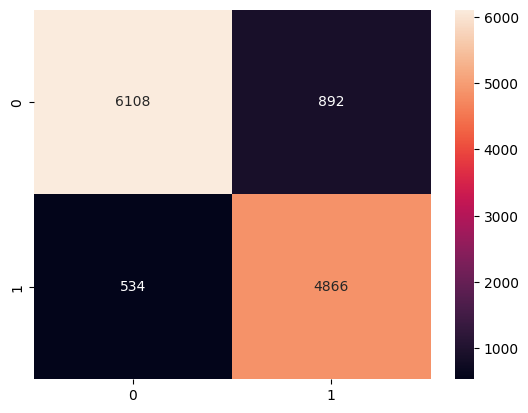

In [15]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_resnet_model(input_shape)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluation
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import time

In [ ]:
np.random.seed(42)
minority_indices = np.where(y == 1)[0]
majority_indices = np.where(y == 0)[0]
n_minority = len(minority_indices)

n_minority_half = n_minority // 2
selected_minority = np.random.choice(minority_indices, size=n_minority_half, replace=False)
selected_majority = np.random.choice(majority_indices, size=n_minority_half, replace=False)

subset_indices = np.concatenate([selected_minority, selected_majority])
np.random.shuffle(subset_indices)
X_subset = X[subset_indices]
y_subset = y[subset_indices]
print(f"Subset created: {len(X_subset)} samples (balanced, 50% of original)")

In [ ]:
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=42
)
X_train_sub_scaled = scaler.transform(X_train_sub.reshape(-1, X_train_sub.shape[-1])).reshape(X_train_sub.shape)
X_val_sub_scaled = scaler.transform(X_val_sub.reshape(-1, X_val_sub.shape[-1])).reshape(X_val_sub.shape)


In [ ]:
def generate_neighbors(current, bounds, step_size=0.05):
    neighbors = []
    for i in range(len(current)):
        for delta in [-step_size, step_size]:
            neighbor = current.copy()
            neighbor[i] = np.clip(neighbor[i] + delta, bounds[i, 0], bounds[i, 1])
            neighbors.append(neighbor)
    return neighbors

In [ ]:
def tabu_search(objective, bounds, n_iterations=5, tabu_size=3, step_size=0.05, verbose=False):
    current = np.random.uniform(low=bounds[:, 0], high=bounds[:, 1])
    current_eval = objective(current)
    
    best = current.copy()
    best_eval = current_eval
    
    tabu_list = []
    
    for iteration in range(n_iterations):
        neighbors = generate_neighbors(current, bounds, step_size)
        best_neighbor = None
        best_neighbor_eval = float('inf')
        
        for neighbor in neighbors:
            neighbor_tuple = tuple(np.round(neighbor, 6))
            
            if neighbor_tuple in tabu_list:
                continue
            eval_val = objective(neighbor)
            if eval_val < best_neighbor_eval:
                best_neighbor = neighbor
                best_neighbor_eval = eval_val
        
        if best_neighbor is None:
            break
        
        current = best_neighbor
        current_eval = best_neighbor_eval
        
        current_tuple = tuple(np.round(current, 6))
        if current_eval < best_eval:
            best = current.copy()
            best_eval = current_eval
            if verbose:
                print(f"  Tabu {iteration+1}/{n_iterations} | Loss: {best_eval:.4f}")
        
        tabu_list.append(current_tuple)
        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)
    
    return best, best_eval


In [ ]:
def objective_function_subset(params):
    dropout_rate, learning_rate = params
    model = build_resnet_model(
        input_shape=(X_train_sub.shape[1], X_train_sub.shape[2]),
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=0)
    history = model.fit(
        X_train_sub_scaled, y_train_sub,
        validation_data=(X_val_sub_scaled, y_val_sub),
        epochs=10,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )
    val_loss = min(history.history['val_loss'])
    del model
    tf.keras.backend.clear_session()
    return val_loss

In [ ]:
def tabu_search_meta_objective(tabu_params):
    n_iterations, tabu_size, step_size = tabu_params
    n_iterations = int(n_iterations)
    tabu_size = int(tabu_size)
    
    print(f"\n  [Testing Tabu params: n_iter={n_iterations}, size={tabu_size}, step={step_size:.4f}]")
    
    model_bounds = np.array([[0.1, 0.5], [0.0001, 0.01]])
    
    best_params, best_loss = tabu_search(
        objective_function_subset,
        model_bounds,
        n_iterations=n_iterations,
        tabu_size=tabu_size,
        step_size=step_size,
        verbose=True
    )
    
    print(f"  [Tabu finished: best_loss={best_loss:.4f}]")
    
    return best_loss

In [ ]:
def simulated_annealing(objective, bounds, n_iterations=5, temp=3.0, cooling_rate=0.9):
    current = np.random.uniform(low=bounds[:, 0], high=bounds[:, 1])
    current_eval = objective(current)
    
    best = current.copy()
    best_eval = current_eval
    
    print(f"SA Initial | Val Loss: {current_eval:.4f} | n_iter: {int(current[0])}, tabu_size: {int(current[1])}, step: {current[2]:.4f}")
    
    for i in range(n_iterations):
        iter_start = time.time()
        
        candidate = current + np.random.normal(0, 0.1, size=len(bounds))
        candidate = np.clip(candidate, bounds[:, 0], bounds[:, 1])
        
        candidate_eval = objective(candidate)
        
        iter_time = time.time() - iter_start
        
        if candidate_eval < current_eval:
            current, current_eval = candidate, candidate_eval
            if candidate_eval < best_eval:
                best, best_eval = candidate, candidate_eval
                print(f"SA Iter {i+1}/{n_iterations} | NEW BEST: {best_eval:.4f} | n_iter: {int(best[0])}, tabu_size: {int(best[1])}, step: {best[2]:.4f} | Time: {iter_time:.1f}s")
        else:
            prob = np.exp((current_eval - candidate_eval) / temp)
            if np.random.rand() < prob:
                current, current_eval = candidate, candidate_eval
                print(f"SA Iter {i+1}/{n_iterations} | Accepted worse | Val Loss: {current_eval:.4f} | Temp: {temp:.2f} | Time: {iter_time:.1f}s")
            else:
                print(f"SA Iter {i+1}/{n_iterations} | Rejected | Val Loss: {candidate_eval:.4f} | Time: {iter_time:.1f}s")
        
        temp *= cooling_rate
    
    return best, best_eval

In [22]:
tabu_bounds = np.array([
    [3, 5],
    [2, 3],
    [0.03, 0.07]
])

print("Starting Simulated Annealing to optimize Tabu Search parameters...")
print("="*70)

best_tabu_params, best_meta_loss = simulated_annealing(
    tabu_search_meta_objective,
    tabu_bounds,
    n_iterations=5,
    temp=3.0,
    cooling_rate=0.9
)

print("="*70)
print(f"\nOptimization Complete!")
print(f"Best Tabu Search Parameters:")
print(f"  n_iterations: {int(best_tabu_params[0])}")
print(f"  tabu_size: {int(best_tabu_params[1])}")
print(f"  step_size: {best_tabu_params[2]:.4f}")
print(f"Best Validation Loss: {best_meta_loss:.4f}")

print("\n" + "="*70)
print("Final Run: Using optimized Tabu Search parameters on full training")
print("="*70)

model_bounds = np.array([[0.1, 0.5], [0.0001, 0.01]])

final_best_params, final_best_loss = tabu_search(
    objective_function_subset,
    model_bounds,
    n_iterations=int(best_tabu_params[0]),
    tabu_size=int(best_tabu_params[1]),
    step_size=best_tabu_params[2],
    verbose=True
)

print(f"\nFinal Optimized Model Parameters:")
print(f"  Dropout Rate: {final_best_params[0]:.4f}")
print(f"  Learning Rate: {final_best_params[1]:.6f}")
print(f"Final Validation Loss: {final_best_loss:.4f}")

Subset created: 27000 samples (balanced, 50% of original)
Starting Simulated Annealing to optimize Tabu Search parameters...

  [Testing Tabu params: n_iter=3, size=2, step=0.0442]
  Tabu 1/3 | Loss: 0.5417
  Tabu 2/3 | Loss: 0.5106
  Tabu 3/3 | Loss: 0.4928
  [Tabu finished: best_loss=0.4928]
SA Initial | Val Loss: 0.4928 | n_iter: 3, tabu_size: 2, step: 0.0442

  [Testing Tabu params: n_iter=3, size=2, step=0.0700]
  Tabu 1/3 | Loss: 0.5342
  Tabu 2/3 | Loss: 0.5314
  Tabu 3/3 | Loss: 0.5139
  [Tabu finished: best_loss=0.5139]
SA Iter 1/5 | Accepted worse | Val Loss: 0.5139 | Temp: 3.00 | Time: 430.9s

  [Testing Tabu params: n_iter=3, size=2, step=0.0700]
  Tabu 2/3 | Loss: 0.5002
  [Tabu finished: best_loss=0.5002]

  [Testing Tabu params: n_iter=3, size=2, step=0.0567]
  Tabu 1/3 | Loss: 0.5175
  Tabu 2/3 | Loss: 0.4965
  [Tabu finished: best_loss=0.4965]

  [Testing Tabu params: n_iter=3, size=2, step=0.0300]
  Tabu 1/3 | Loss: 0.5214
  Tabu 3/3 | Loss: 0.5149
  [Tabu finished: b

***resnet Model on Optimized Tabu Parameters***

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
final_dropout_rate = 0.2396
final_learning_rate = 0.001064

In [26]:
input_shape = (X_train.shape[1], X_train.shape[2])
final_model = build_resnet_model(
    input_shape=input_shape,
    dropout_rate=final_dropout_rate,
    learning_rate=final_learning_rate
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
]

X_train_full = np.concatenate([X_train_scaled, X_val_scaled], axis=0)
y_train_full = np.concatenate([y_train, y_val], axis=0)

print(f"Training on full training + validation set: {len(X_train_full)} samples")
print("Starting final training...\n")

Training on full training + validation set: 49600 samples
Starting final training...



In [27]:

history = final_model.fit(
    X_train_full, y_train_full,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.6609 - auc_1: 0.7074 - loss: 0.6215 - learning_rate: 0.0011
Epoch 2/100
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7093 - auc_1: 0.7731 - loss: 0.5665 - learning_rate: 0.0011
Epoch 3/100
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7307 - auc_1: 0.7989 - loss: 0.5392 - learning_rate: 0.0011
Epoch 4/100
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7495 - auc_1: 0.8230 - loss: 0.5102 - learning_rate: 0.0011
Epoch 5/100
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7675 - auc_1: 0.8441 - loss: 0.4826 - learning_rate: 0.0011
Epoch 6/100
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7885 - auc_1: 0.8644 - loss: 0.4541 - learning_rate: 0.0011
Epoch 7/100
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8023 - auc_1: 0.8812 - loss: 0.4271 - learning_rate: 0.0011
Epoch 8/100
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8216 - auc_1: 0.8978 - loss

In [28]:
print("\n" + "="*60)
print("FINAL EVALUATION ON TEST SET")
print("="*60)

y_pred_prob = final_model.predict(X_test_scaled).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)



FINAL EVALUATION ON TEST SET
388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [29]:

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      7000
           1       0.90      0.93      0.91      5400

    accuracy                           0.92     12400
   macro avg       0.92      0.93      0.92     12400
weighted avg       0.93      0.92      0.92     12400



In [30]:
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC AUC Score: {auc_score:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


ROC AUC Score: 0.9743

Confusion Matrix:
[[6426  574]
 [ 366 5034]]


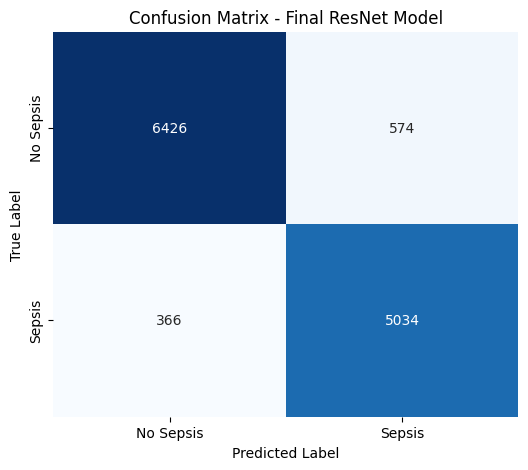

In [32]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Sepsis', 'Sepsis'],
            yticklabels=['No Sepsis', 'Sepsis'])
plt.title('Confusion Matrix - Final ResNet Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Final ResNet Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

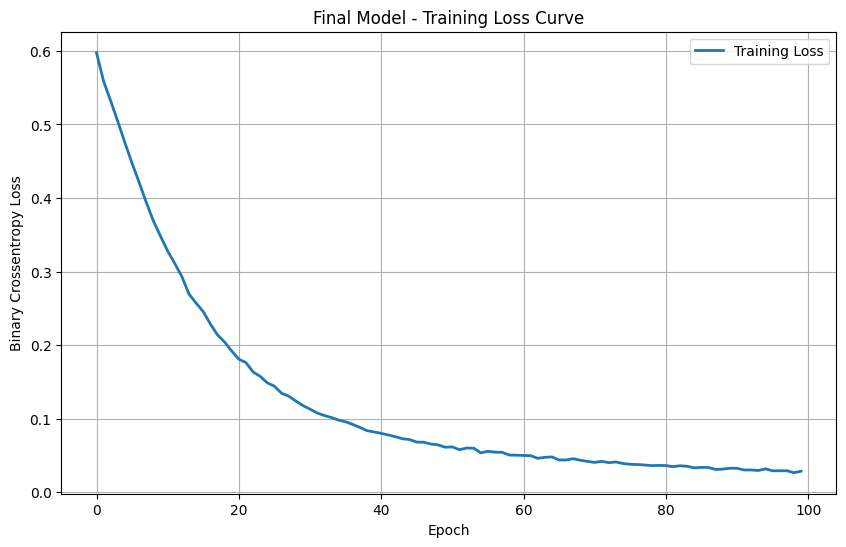

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.title('Final Model - Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import shap
import matplotlib.pyplot as plt

In [34]:
def gwo_initialize(n_wolves, bounds):
    bounds = np.array(bounds)
    n_dim = bounds.shape[0]
    positions = np.random.uniform(
        low=bounds[:, 0],
        high=bounds[:, 1],
        size=(n_wolves, n_dim)
    )
    return positions, bounds, n_dim

In [35]:
def gwo_evaluate(positions, objective):
    n_wolves = positions.shape[0]
    scores = np.full(n_wolves, np.inf)
    for i in range(n_wolves):
        scores[i] = objective(positions[i])
    return scores

In [36]:
def gwo_update_leaders(positions, scores):
    sorted_idx = np.argsort(scores)
    alpha_pos = positions[sorted_idx[0]].copy()
    beta_pos = positions[sorted_idx[1]].copy()
    delta_pos = positions[sorted_idx[2]].copy()
    alpha_score = scores[sorted_idx[0]]
    return alpha_pos, beta_pos, delta_pos, alpha_score

In [37]:
def gwo_optimize(objective, bounds, n_wolves=10, n_iterations=5):
    positions, bounds, n_dim = gwo_initialize(n_wolves, bounds)
    scores = gwo_evaluate(positions, objective)
    alpha_pos, beta_pos, delta_pos, alpha_score = gwo_update_leaders(positions, scores)
    
    for t in range(n_iterations):
        a = 2 - t * (2 / n_iterations)  # decreases from 2 to 0
        
        for i in range(n_wolves):
            for j in range(n_dim):
                # Towards alpha
                r1, r2 = np.random.random(2)
                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                D_alpha = abs(C1 * alpha_pos[j] - positions[i, j])
                X1 = alpha_pos[j] - A1 * D_alpha
                
                # Towards beta
                r1, r2 = np.random.random(2)
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_beta = abs(C2 * beta_pos[j] - positions[i, j])
                X2 = beta_pos[j] - A2 * D_beta
                
                # Towards delta
                r1, r2 = np.random.random(2)
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_delta = abs(C3 * delta_pos[j] - positions[i, j])
                X3 = delta_pos[j] - A3 * D_delta
                
                new_pos = (X1 + X2 + X3) / 3
                positions[i, j] = np.clip(new_pos, bounds[j, 0], bounds[j, 1])
            
            scores[i] = objective(positions[i])
            
            if scores[i] < alpha_score:
                alpha_score = scores[i]
                alpha_pos = positions[i].copy()
                beta_pos = positions[np.argsort(scores)[1]].copy()
                delta_pos = positions[np.argsort(scores)[2]].copy()
        
        print(f"GWO Iteration {t+1}/{n_iterations} | Best Val Loss: {alpha_score:.4f}")
    
    return alpha_pos, alpha_score

In [39]:
# Objective function for GWO
def gwo_objective(params):
    dropout_rate, learning_rate = params
    
    model = build_resnet_model(
        input_shape=(X_train_sub.shape[1], X_train_sub.shape[2]),
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )
    
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)
    
    history = model.fit(
        X_train_sub_scaled, y_train_sub,
        validation_data=(X_val_sub_scaled, y_val_sub),
        epochs=15,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )
    
    val_loss = min(history.history['val_loss'])
    
    del model
    tf.keras.backend.clear_session()
    
    return val_loss

In [ ]:
gwo_bounds = [[0.1, 0.5], [0.0001, 0.01]]

print("Starting Grey Wolf Optimizer (GWO) for hyperparameter tuning...")
print("="*70)

best_params, best_loss = gwo_optimize(
    objective=gwo_objective,
    bounds=gwo_bounds,
    n_wolves=10,
    n_iterations=15
)

best_dropout = best_params[0]
best_lr = best_params[1]

print("="*70)
print("GWO Optimization Complete!")
print(f"Best Dropout Rate: {best_dropout:.4f}")
print(f"Best Learning Rate: {best_lr:.6f}")
print(f"Best Validation Loss: {best_loss:.4f}")

Starting Grey Wolf Optimizer (GWO) for hyperparameter tuning...
GWO Iteration 1/15 | Best Val Loss: 0.4843


In [ ]:
final_model_gwo = build_resnet_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    dropout_rate=best_dropout,
    learning_rate=best_lr
)

callbacks_final = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
]

X_train_full = np.concatenate([X_train_scaled, X_val_scaled], axis=0)
y_train_full = np.concatenate([y_train, y_val], axis=0)

In [ ]:
history_final = final_model_gwo.fit(
    X_train_full, y_train_full,
    epochs=100,
    batch_size=32,
    callbacks=callbacks_final,
    verbose=1
)

In [ ]:
# Final evaluation
y_pred_prob = final_model_gwo.predict(X_test_scaled).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)
print("\nFinal Test ROC AUC:", tf.keras.metrics.AUC()(y_test, y_pred_prob).numpy())

In [ ]:
print("\nComputing SHAP values...")
background = X_train_scaled[np.random.choice(len(X_train_scaled), 100, replace=False)]
explainer = shap.KernelExplainer(final_model_gwo.predict, background)
shap_values = explainer.shap_values(X_test_scaled[:10])

shap.summary_plot(shap_values, X_test_scaled[:10], feature_names=feature_cols, show=False)
plt.title("SHAP Summary Plot")
plt.show()

In [ ]:
def gradcam_heatmap(model, sample, layer_name="conv1d_5"):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(sample)
        class_score = preds[:, 0]
    grads = tape.gradient(class_score, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    heatmap = tf.reduce_mean(conv_out[0] * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if heatmap.max() > 0:
        heatmap /= heatmap.max()
    return heatmap

In [ ]:
sepsis_idx = np.where(y_test == 1)[0][0]
sample = X_test_scaled[sepsis_idx:sepsis_idx+1]
heatmap = gradcam_heatmap(final_model_gwo, sample)

plt.figure(figsize=(12, 4))
plt.plot(heatmap)
plt.title("Grad-CAM: Important Time Steps (Sepsis Sample)")
plt.xlabel("Time Step")
plt.ylabel("Importance")
plt.show()

print("GWO optimization + XAI complete!")